In [92]:
import yfinance as yf
import pandas as pd
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import precision_score

In [93]:
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period = "max")

meta = yf.Ticker("META")
meta = meta.history(period = "max")

apple = yf.Ticker("AAPL")
apple = apple.history(period = "max")

amazon = yf.Ticker("AMZN")
amazon = amazon.history(period = "max")

netflix = yf.Ticker("NFLX")
netflix = netflix.history(period = "max")

google = yf.Ticker("GOOGL")
google = google.history(period = "max")


<Axes: xlabel='Date'>

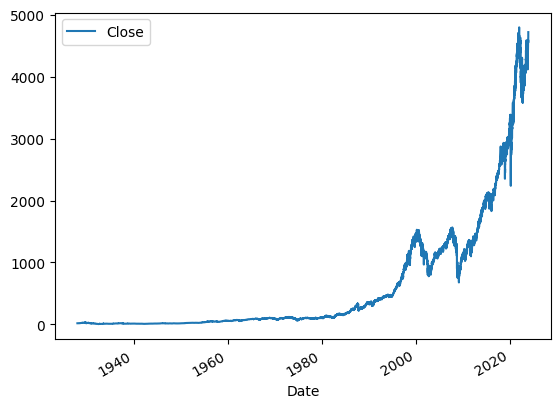

In [94]:
sp500.plot.line(y="Close",use_index=True)

In [95]:
del sp500["Dividends"]
del sp500["Stock Splits"]

del meta["Dividends"]
del meta["Stock Splits"]

del apple["Dividends"]
del apple["Stock Splits"]

del amazon["Dividends"]
del amazon["Stock Splits"]

del netflix["Dividends"]
del netflix["Stock Splits"]

del google["Dividends"]
del google["Stock Splits"]

In [96]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)
sp500 = sp500.loc["1990-01-01":].copy()

In [97]:
sp500 = sp500.loc["1990-01-01":].copy()
train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"] 
model.fit(train[predictors], train["Target"])
RandomForestClassifier(min_samples_split = 1, random_state = 1)

RandomForestClassifier(min_samples_split=1, random_state=1)

In [98]:
preds = model.predict(test[predictors])
preds = pd.Series(preds, index = test.index)
precision_score(test["Target"], preds)

0.4861111111111111

<Axes: xlabel='Date'>

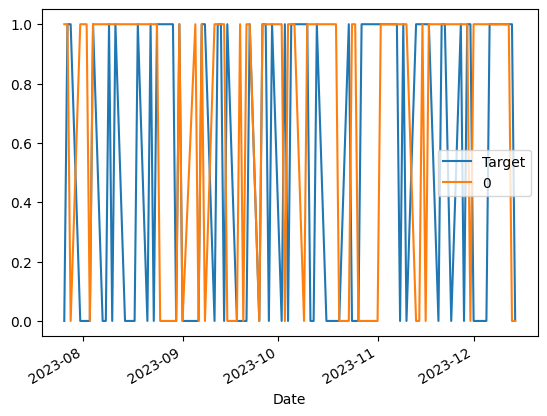

In [99]:
combined = pd.concat([test["Target"], preds] , axis = 1)
combined.plot()

In [100]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index = test.index, name = "Predictions")
    combined = pd.concat([test["Target"], preds], axis =1)
    return combined
    

In [101]:
def backtest(data, model, predictors, start = 2500, step = 250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train,test, predictors,model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [102]:
predictions = backtest(sp500, model, predictors)

In [103]:
predictions["Predictions"].value_counts()

Predictions
0    3533
1    2522
Name: count, dtype: int64

In [104]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5297383029341792

In [105]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.534269
0    0.465731
Name: count, dtype: float64

In [106]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [107]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [108]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [109]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [110]:
predictions = backtest(sp500, model, new_predictors)

In [111]:
predictions["Predictions"].value_counts()

Predictions
0.0    4225
1.0     830
Name: count, dtype: int64

In [112]:
precision_score(predictions["Target"], predictions["Predictions"])

0.572289156626506

In [113]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.544016
0    0.455984
Name: count, dtype: float64